# Forest Offsets Paper — Figure 4


In [1]:
import os
import fsspec
import json
import geopandas
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.geometry import Point


crs = "+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs=True"

In [2]:
## Load the data

with fsspec.open(
    "https://carbonplan.blob.core.windows.net/carbonplan-forests/offsets/database/forest-offsets-database-v1.0.json",
    "r",
) as f:
    db = json.load(f)

In [3]:
ecomap_sections = geopandas.read_file(
    "https://carbonplan.blob.core.windows.net/carbonplan-forests/offsets/archive/inputs/ancillary/ecomap_sections.json"
).to_crs("epsg:4326")

In [4]:
arbitrage_df = geopandas.read_file(
    "https://carbonplan.blob.core.windows.net/carbonplan-forests/offsets/archive/results/79.json"
)

In [5]:
states = geopandas.read_file(
    "https://carbonplan.blob.core.windows.net/carbonplan-forests/offsets/archive/inputs/ancillary/states.json"
)

In [6]:
ecosections = ["M261A", "M261B", "M261D"]

In [7]:
proj_centroids = {
    project["opr_id"]: Point(project["shape_centroid"][0][0], project["shape_centroid"][0][1])
    for project in db
    if (79 in project["supersection_ids"])
    and (
        project["carbon"]["initial_carbon_stock"]["value"]
        > project["carbon"]["common_practice"]["value"]
    )
    # and (project['opr_id'] != 'CAR1102')
}

In [8]:
proj_points = geopandas.GeoDataFrame(
    data=list(proj_centroids.keys()), geometry=list(proj_centroids.values()), crs="epsg:4326"
)

In [9]:
conus = [
    "AL",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "FL",
    "GA",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
]
states = states.loc[states["postal"].isin(conus)]
outline_states = states.dissolve("adm0_a3")

sub_states = states.loc[states["postal"].isin(["CA", "OR"])]

In [10]:
arbitrage_df.mean_local_slag.mean()

96.01933245083995

In [11]:
vmin, vmax = arbitrage_df.mean_local_slag.quantile(0.025), arbitrage_df.mean_local_slag.quantile(
    0.975
)

norm = mpl.colors.Normalize(vmin, vmax)

In [12]:
rfia_mean = 119.05
slag_per_section = {
    "M261B": 150.5 - rfia_mean,
    "M261A": 120.6 - rfia_mean,
    "M261D": 95.2 - rfia_mean,
}

In [13]:
def make_colormap():
    N = 256
    vals1 = np.ones((N, 4))
    vals1[:, 0] = np.linspace(126 / 256, 1, N)
    vals1[:, 1] = np.linspace(179 / 256, 1, N)
    vals1[:, 2] = np.linspace(106 / 256, 1, N)
    vals2 = np.ones((N, 4))
    vals2[:, 0] = np.linspace(128 / 256, 1, N)
    vals2[:, 1] = np.linspace(128 / 256, 1, N)
    vals2[:, 2] = np.linspace(128 / 256, 1, N)
    return mpl.colors.ListedColormap(np.concatenate([vals2, vals1[::-1]]))

In [14]:
cp_cm = make_colormap()
ecomap_colors = cp_cm(norm(list(slag_per_section.values())))
ecomap_cmap = ListedColormap(ecomap_colors[::-1], name="ecomap")

In [15]:
supersection_sections = (
    ecomap_sections.loc[ecomap_sections["MAP_UNIT_S"].isin(ecosections)].to_crs(crs).copy()
)
supersection_sections["slag"] = supersection_sections["MAP_UNIT_S"].map(slag_per_section)
supersection_outline = supersection_sections.dissolve("PROJECT")

<ipython-input-16-5e0c22e0c89a>:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


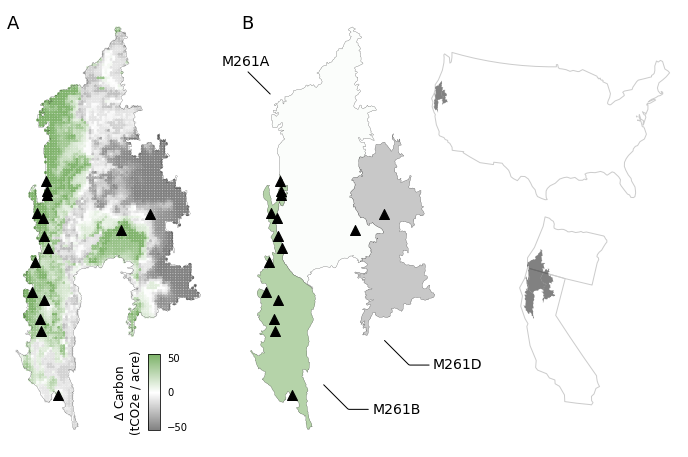

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(7, 7))


left, bottom, width, height = 0.3, 0.1, 0.025, 0.15
cax = fig.add_axes([left, bottom, width, height])

arbitrage_df.to_crs(crs).plot(
    "delta_slag",
    markersize=4.5,
    ax=ax[0],
    cmap=cp_cm,
    legend=True,
    cax=cax,
    vmin=-55,
    vmax=55,
    legend_kwds={"label": "", "orientation": "vertical"},
)
cax.set_ylabel("$\Delta$ Carbon\n(tCO2e / acre)", loc="center", labelpad=-75, fontsize=12)
cax.yaxis.set_ticks_position("none")

proj_points.to_crs(crs).plot(ax=ax[0], marker="^", color="k", markersize=100, edgecolor=None)
supersection_outline.plot(ax=ax[0], edgecolor="k", lw=0.2, color="None")

supersection_sections.plot(
    column="slag",
    ax=ax[1],
    edgecolor="k",
    lw=0.2,
    cmap=cp_cm,
    vmin=-55,
    vmax=55,
)
proj_points.to_crs(crs).plot(ax=ax[1], marker="^", color="k", markersize=100, edgecolor=None)


xys = {"M261D": (0.7, 0.25), "M261A": (0.15, 0.8), "M261B": (0.4, 0.15)}
xyoffsets = {
    "M261D": (50, -30),
    "M261A": (-50, 30),
    "M261B": (50, -30),
}
connections = {
    "M261D": "angle,angleA=0,angleB=-45,rad=1",
    "M261A": "angle,angleA=0,angleB=-45",
    "M261B": "angle,angleA=0,angleB=-45,rad=1",
}


for key in xys.keys():

    ax[1].annotate(
        text=key,
        xy=xys[key],
        annotation_clip=False,
        xycoords="axes fraction",
        fontsize=14,
        xytext=xyoffsets[key],
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-", connectionstyle=connections[key]),
    )
width = 4.5
inset = inset_axes(
    ax[1],
    width=width,
    height=width / 2,
    bbox_to_anchor=(1.8, 0.65, 0.55, 0.275),
    bbox_transform=ax[1].transAxes,
)
outline_states.to_crs(crs).plot(ax=inset, color="None", edgecolor=".8")
supersection_sections.to_crs(crs).plot(ax=inset, color=".1", alpha=0.55)
inset.axes.set_axis_off()

inset_2 = inset_axes(
    ax[1],
    width=4 / 3,
    height=4,
    bbox_to_anchor=(1.1, 0.4, 0.75, 0.25),
    bbox_transform=ax[1].transAxes,
)
sub_states.to_crs(crs).plot(ax=inset_2, color="None", edgecolor=".8")
supersection_sections.to_crs(crs).plot(ax=inset_2, color=".1", alpha=0.55)

inset_2.axes.set_axis_off()

ax[0].set_axis_off()
ax[1].set_axis_off()

for a, text in zip(ax, ["A", "B"]):
    a.annotate(text, xy=(0, 0.95), xycoords="axes fraction", fontsize=18)

fig.tight_layout()

fname = "Figure-4.svg"
if "BLOB_ACCOUNT_KEY" in os.environ:
    with fsspec.open(
        f"az://carbonplan-forests/offsets/figures/raw/{fname}",
        "w",
        account_name="carbonplan",
        account_key=os.environ["BLOB_ACCOUNT_KEY"],
    ) as f:
        fig.savefig(f, format="svg", dpi=300, bbox_inches="tight")
else:
    plt.savefig(fname, dpi=300, bbox_inches="tight")